# Proyecto Final Lab Inteligencia (Imagenes): Método alternativo 

In [16]:
#Imports
import matplotlib.pyplot as plt
import numpy as np
import cv2
from scipy.spatial import distance as dist
import argparse
import glob
from skimage.feature import hog
from skimage import exposure

## 7) Uso de un método alternativo para la extracción de características

Se utiliza el método HoG (Histograms of Gradients) para realizar la extracción de caractrísticas. Se reutilizan varias de las funciones utilizadas anteriormente.

### 7.1) Lectura de imagen (en RGB)

In [2]:
#Funcion que lear una imagen a RGB
def leerRGB (nombreImagen):
    #Lectura
    readImage = cv2.imread(nombreImagen)
    return readImage

In [23]:
test = leerRGB('100501.jpg')

In [24]:
cv2.imshow('image',test)
cv2.waitKey(0)
cv2.destroyAllWindows()

### 7.2) División de la imagen en razones 1:2 (6filasx3columas)

In [190]:
#Funcion que recorte la imagen en 6x3 celdas. Devuelve 18 submatrices.
def divCeldasAlt(imRGB):
    #division
    R = imRGB[:,:,0]
    G = imRGB[:,:,1]
    B = imRGB[:,:,2]
    #Dimensiones de la imagen
    alto,ancho,prof = imRGB.shape
    #Nuevas dimensiones
    nuevoAlto = int(alto/6)
    nuevoAncho = int(ancho/3)
    #Creacion de las tres matrices (inicialmente vacias).
    Rdiv = np.zeros([nuevoAlto,nuevoAncho,18])
    Gdiv = np.zeros([nuevoAlto,nuevoAncho,18])
    Bdiv = np.zeros([nuevoAlto,nuevoAncho,18])
    #Dividir imagen
    vecDivisionesAlto = [0,nuevoAlto,nuevoAlto,nuevoAlto*2,nuevoAlto*2,nuevoAlto*3,nuevoAlto*3,nuevoAlto*4,nuevoAlto*4,nuevoAlto*5,nuevoAlto*5,nuevoAlto*6]
    vecDivisionesAncho = [0,nuevoAncho,nuevoAncho,nuevoAncho*2,nuevoAncho*2,nuevoAncho*3]
    count = 0
    count1 = 0
    while count1 <= 11:
        count2 = 0
        while count2 <= 5:
            Rdiv[:,:,count] = R[vecDivisionesAlto[count1]:vecDivisionesAlto[count1+1],vecDivisionesAncho[count2]:vecDivisionesAncho[count2+1]]
            Gdiv[:,:,count] = G[vecDivisionesAlto[count1]:vecDivisionesAlto[count1+1],vecDivisionesAncho[count2]:vecDivisionesAncho[count2+1]]
            Bdiv[:,:,count] = B[vecDivisionesAlto[count1]:vecDivisionesAlto[count1+1],vecDivisionesAncho[count2]:vecDivisionesAncho[count2+1]]
            count += 1
            count2 += 2
        count1 +=2  
        
    return np.uint8(Rdiv),np.uint8(Gdiv),np.uint8(Bdiv)

### 7.3) Cálculo de HoG

In [43]:
#Funcion que calcule el vector de características de una imagen
def caracteristicasHOG(imRGB):
    vectorCar = hog(test, orientations = 9, pixels_per_cell = (16,16), cells_per_block = (1,1), block_norm = 'L2-Hys', visualize = False, feature_vector = True, multichannel = True)
    return vectorCar

Ejemplo de funcionamiento del método, se utiliza esto para elegir el número de bins y pixeles por cell.

In [41]:
vectorCar,hogImage = hog(test, orientations = 9, pixels_per_cell = (16,16), cells_per_block = (1,1), block_norm = 'L2-Hys', visualize = True, feature_vector = True, multichannel = True)

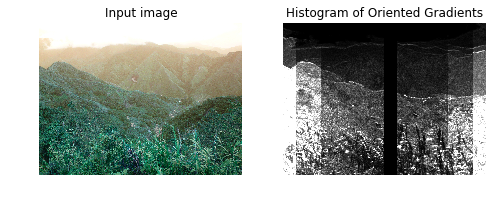

In [42]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(test, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hogImage, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

### 7.4) Definición de medidad de comparación 

In [48]:
def compareEuc(hist1,hist2):
    #Comparar.
    distancia = dist.euclidean(hist1, hist2,1)
    return distancia

### 7.5) Orden de resultados por relevancia.

#### 7.5.1) Incorporación de imagenes de la base de datos

Se realiza una adaptación del archivo anterior.

In [49]:
def extraerClaseAlternativo(stringClase):
    #Extraer la clase de la imagen
    clase = stringClase[1:4]
    claseNum = int(clase)
    return claseNum 

def incorporarDatabaseAlternativo():
    #Funcion que incorpore elementos del database, con el fin posterior de realizar las comparaciones.
    #Inicializa images para almacenar las imágenes
    images = {}
    #Recorrer el directorio
    #Directorio
    path = "img_database/*.jpg"
    #Loop.
    for imPath in glob.glob(path):
        #Nombre del archivo
        filename = imPath[imPath.rfind("\\")+1:]
        #Importar
        image = cv2.imread(imPath)
        #Almacenar en imagenes.
        images[filename] = image
    return images

def incorporarDatabaseHistAlternativo():
    #Funcion que calcule los histogramas del Database.
    # Inicializa el diccionario index, para almacenar el nombre de imagen con su histograma
    path = "img_database/*.jpg"
    #Creación de arreglos
    nombres = np.array([])
    clases = np.array([])
    histos = np.array([])
    count = 0
    #Loop.
    for imPath in glob.glob(path):
        #Nombre del archivo
        filename = imPath[imPath.rfind("\\")+1:]
        #Agregar nombre y clase
        nombres = np.append(nombres,str(filename))
        clases = np.append(clases,extraerClaseAlternativo(filename))
        #Obtener el histograma
        print(filename)
        imagenSubida = leerRGB(imPath)
        histImagen = caracteristicasHOG(imagenSubida)
        #Incluir histograma
        if (count==0):
            histos=histImagen.T
            count = 1
        elif(count==1):
            histos = np.concatenate(([histos],[histImagen.T]),axis=0)
            count = 2
        else:
            histos = np.concatenate((histos,np.array([histImagen])),axis=0)
    return nombres,clases,histos

In [50]:
nombresHoG,clasesHoG,histosHoG = incorporarDatabaseHistAlternativo()

100501.jpg
100502.jpg
100503.jpg
101501.jpg
101502.jpg
101503.jpg
101504.jpg
102301.jpg
102302.jpg
102303.jpg
103501.jpg
103502.jpg
103503.jpg
104001.jpg
104002.jpg
104003.jpg
104004.jpg
104005.jpg
104006.jpg
104201.jpg
104202.jpg
104203.jpg
105101.jpg
105102.jpg
105103.jpg
105104.jpg
106401.jpg
106402.jpg
106403.jpg
106601.jpg
106602.jpg
106603.jpg
106604.jpg
106605.jpg
106606.jpg
107201.jpg
107202.jpg
107203.jpg
108101.jpg
108102.jpg
108103.jpg
108104.jpg
108105.jpg
108201.jpg
108202.jpg
108203.jpg
111701.jpg
111702.jpg
111703.jpg
112401.jpg
112402.jpg
112403.jpg
112404.jpg
112405.jpg
112406.jpg
112407.jpg
112408.jpg
113401.jpg
113402.jpg
113403.jpg
113404.jpg
114501.jpg
114502.jpg
114503.jpg
114504.jpg
114601.jpg
114701.jpg
114702.jpg
114703.jpg
115601.jpg
115602.jpg
116801.jpg
116802.jpg
116803.jpg
118001.jpg
118002.jpg
118003.jpg
119701.jpg
119702.jpg
119703.jpg
119704.jpg
120701.jpg
120702.jpg
120703.jpg
120801.jpg
120901.jpg
121001.jpg
121101.jpg
121201.jpg
121301.jpg
121401.jpg

#### 7.6.2) Comparación de Queries versus la  base de datos.

In [60]:
def distanciaUnaImagenAlt(nombreImagenQuery):
    #Leer imagen de la query
    imagenQuery = leerRGB (nombreImagenQuery)
    #Obtener histograma de la imagen query.
    histQuery = caracteristicasHOG(imagenQuery)
    #Seleccion de la matriz de histogramas a comparar.
    histComparar = histosHoG
    #Comparaciones:
    comparaciones = np.array([])
    for h in histComparar:
        distancia = compareEuc(h,histQuery)
        comparaciones = np.append(comparaciones,distancia)
    return comparaciones

In [65]:
def compararQueriesAlt():
    #Funcion que compare las queries para el metodo alternativo
    # Inicializa el diccionario index, para almacenar el nombre de imagen con su histograma
    path2 = "img_query/*.jpg"
    #Creación de arreglos
    nombres = np.array([])
    clases = np.array([])
    comparaciones = np.array([])
    #Loop.
    count = 0
    for imPath in glob.glob(path2):
        #Nombre del archivo
        posName = imPath.rfind("\\")
        filename2 = imPath[posName + 1:]
        #Calcular vector de comparaciones y la clase
        vecComparaciones = distanciaUnaImagenAlt(imPath)
        #Agregar nombre
        nombres = np.append(nombres,str(filename2))
        #Incluir clases
        clases = np.append(clases,extraerClaseAlternativo(filename2))
        #Incluir histograma
        if (count==0):
            comparaciones=vecComparaciones.T
            count = 1
        elif(count==1):
            comparaciones = np.concatenate(([comparaciones],[vecComparaciones.T]),axis=0)
            count = 2
        else:
            comparaciones = np.concatenate((comparaciones,[vecComparaciones]),axis=0)
    return nombres,clases,comparaciones

In [66]:
nombresQueryAlt,clasesQueryAlt,compQueryAlt = compararQueriesAlt()

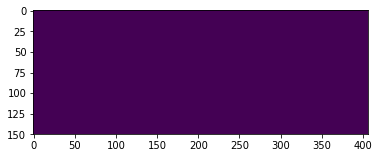

In [73]:
plt.imshow(compQueryAlt)

### 7.7) Cálculo del Rank normalizado.

In [81]:
def ordenarVector(vectorComparaciones,vecClases,vecNombres):
    #Funcion que ordene un vector de comparaciones de acuerdo a la distancia. Adicionalmente debe ordenar las clases asociadas
    #y los nombres de las figuras.
    orden = np.argsort(vectorComparaciones)
    #Ordenar
    #Comparaciones
    comparacionesOrdenado =np.sort(vectorComparaciones)
    #Ordenar clases y nombres
    clasesOrdenado = np.zeros_like(vecClases)
    nombresOrdenado = np.zeros_like(vecNombres)
    count = 0
    for i in orden:
        clasesOrdenado[count] = vecClases[i]
        nombresOrdenado[count] = vecNombres[i]
        count += 1
    return comparacionesOrdenado,clasesOrdenado,nombresOrdenado   

#Funcion que calcule el Rank Normalizado para las figuras.
def rankNormalizadoIndividual(claseQuery,vectorComparaciones,vecNombresData):
    #Numero total de elementos en el conjunto.
    N = len(nombresHoG)    #Elementos del conjunto de la misma clase que el elemnto de la Query.
    Nrel = np.count_nonzero(clasesHoG == claseQuery)
    #Ordenar comparaciones y datos. Ordenamiento de acuerdo al valor del vector de comparaciones.
    comparacionesOrdenado,clasesOrdenado,nombresOrdenado = ordenarVector(vectorComparaciones,clasesHoG,vecNombresData)
    #Calculo del rank normalizado.
    factor1 = 1/(N*Nrel)
    factor2 = (Nrel*(Nrel+1))/(2)
    sumaR = np.sum(np.ravel(np.argwhere(clasesOrdenado==claseQuery)))
    rankNorm = factor1 * (sumaR - factor2)
    return rankNorm,nombresOrdenado

In [82]:
#Funcion que calcule el rank normalizado promedio de todas las figuras query.
def rankNormalizadoQuery(vecClasesQuery,matComparacionesQuery,vecNombresData):
    #Funcion que calcule el rank promedio de todas las query.
    count = 0
    rankTot = 0
    for vecComparacionesQuery in matComparacionesQuery:
        rank,nameOrdenado = rankNormalizadoIndividual(vecClasesQuery[count],vecComparacionesQuery,vecNombresData)
        rankTot = np.append(rankTot,rank)
        count += 1
    rankPromedio = np.mean(rankTot)
    return rankPromedio

In [83]:
promRankNormalizadoAlt = rankNormalizadoQuery(clasesQueryAlt,compQueryAlt,nombresHoG,)

In [84]:
print(promRankNormalizadoAlt)

0.5097070063957482
